# Przygotowanie analizy RFM dla wszystkich kupujących w okresie

In [ ]:
import numpy as np 
import pandas as pd
import math
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('ticks')
sns.set_palette("deep")

In [ ]:
df_oct = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/archive/2019-Oct_purchase.csv", index_col=0)

df_nov = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/archive/2019-Nov_purchase.csv", index_col=0)

df_dec = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/archive/2019-Dec_purchase.csv", index_col=0)

df_jan = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/archive/2020-Jan_purchase.csv", index_col=0)

df_feb = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/archive/2020-Feb_purchase.csv", index_col=0)

df_mar = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/archive/2020-Mar_purchase.csv", index_col=0)

df_apr = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/archive/2020-Apr_purchase.csv", index_col=0)

In [ ]:
# połączenie dataframeów
frames = [df_oct, df_nov, df_dec, df_jan, df_feb, df_mar, df_apr]
df_rfm = pd.concat(frames).reset_index(drop=True)

df_rfm

,event_time,event_type,product_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:02:14 UTC,purchase,1004856,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564
1,2019-10-01 00:04:37 UTC,purchase,1002532,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
2,2019-10-01 00:07:07 UTC,purchase,13800054,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f
3,2019-10-01 00:09:26 UTC,purchase,4804055,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553
4,2019-10-01 00:09:54 UTC,purchase,4804056,electronics.audio.headphone,apple,161.98,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
...,...,...,...,...,...,...,...,...
5707918,2020-04-30 23:57:46 UTC,purchase,100060789,apparel.trousers,glo,18.02,571148166,c0453474-a59d-4c8e-9232-abe4718f6126
5707919,2020-04-30 23:57:52 UTC,purchase,1004229,construction.tools.light,apple,952.15,647021522,1bfa9fe6-7fdb-4c0a-b317-65780ab610ac
5707920,2020-04-30 23:59:03 UTC,purchase,1004226,construction.tools.light,apple,807.20,648063263,36b0e662-5456-4dac-9ab1-b8c7245dbbd2
5707921,2020-04-30 23:59:32 UTC,purchase,4802161,sport.bicycle,jbl,10.53,621887055,a48325b5-a58c-4016-a876-8fe6c9b7dfec


In [ ]:
df_rfm.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5707923 entries, 0 to 5707922
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   event_time     5707923 non-null  object 
 1   event_type     5707923 non-null  object 
 2   product_id     5707923 non-null  int64  
 3   category_code  5707923 non-null  object 
 4   brand          5707923 non-null  object 
 5   price          5707923 non-null  float64
 6   user_id        5707923 non-null  int64  
 7   user_session   5707923 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 348.4+ MB


In [ ]:
#usunięcie kolumny z dodatkowym indexem
df_rfm = df_rfm.loc[:,~df_rfm.columns.str.match("Unnamed")]

# wycięcie pierwszych 10 znaków i zmiana na datetime
df_rfm['event_time'] = df_rfm['event_time'].apply(lambda s: str(s)[0:10])
df_rfm['event_time'] = pd.to_datetime(df_rfm['event_time'], format='%Y-%m-%d')

# recency od ostatniego zakupu w zbiorze
max_date = df_rfm['event_time'].max()
df_rfm = df_rfm.groupby(['user_id']).agg({'event_time': lambda x : (max_date - x.max()).days,'user_session':'count','price': 'sum'})

# zmiana nazw kolumn
df_rfm.rename(columns={'event_time':'recency','user_session':'frequency','price':'monetary'}, inplace=True)
df_rfm.reset_index(inplace=True)

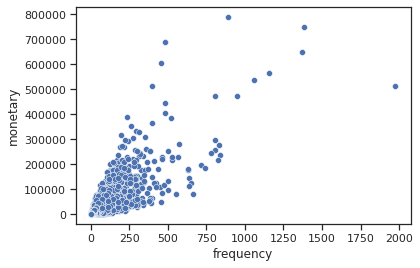

In [ ]:
sns.scatterplot(x='frequency', y='monetary', data=df_rfm)
plt.show()

In [ ]:
df_rfm

,user_id,recency,frequency,monetary
0,101875240,105,1,184.52
1,107620212,91,1,244.28
2,128968633,121,3,358.79
3,136662675,139,1,102.65
4,145611266,16,2,81.56
...,...,...,...,...
1817168,649770286,0,1,948.77
1817169,649770487,0,1,143.89
1817170,649770848,0,2,700.10
1817171,649771260,0,1,353.77


In [ ]:
df_rfm.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1817173 entries, 0 to 1817172
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1817173 non-null  int64  
 1   recency    1817173 non-null  int64  
 2   frequency  1817173 non-null  int64  
 3   monetary   1817173 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 55.5 MB


In [ ]:
df_rfm.to_csv(r'/content/drive/MyDrive/Colab Notebooks/archive/all_months_rfm.csv')